In [1]:
# Cell 1: pick one intermediates file + load it
from pathlib import Path
import numpy as np

# Point this to one run
run_dir = Path("./output/probing_global/scene_description_balanced_2d_qwen2.5-VL-7B-Instruct/probes")
inter_dir = run_dir / "intermediates"

# Pick a specific layer+seed file (edit as needed)
npz_path = inter_dir / "X_0_seed0.npz"
z = np.load(npz_path)

print("Keys:", z.files)
print("n_samples (test):", z["y_score"].shape[0])
print("n_pairs:", z["y_score"].shape[1])


Keys: ['idx_test', 'triplet_count_per_sample', 'n_implied_absent_pairs_per_sample', 'y_present', 'y_implied_absent', 'y_non_implied_absent', 'y_score', 'y_pred', 'n_total_absent_pairs_per_sample', 'implied_absent_density_per_sample', 'sample_id', 'pair_colors', 'pair_shapes']
n_samples (test): 740
n_pairs: 100


In [2]:
# Cell 2: select one sample from the test set (by index within this npz)
i = 0  # change this to inspect different samples

triplet = int(z["triplet_count_per_sample"][i])
sample_id = int(z["sample_id"][i]) if "sample_id" in z else None

n_implied = int(z["n_implied_absent_pairs_per_sample"][i])
n_total_absent = int(z["n_total_absent_pairs_per_sample"][i]) if "n_total_absent_pairs_per_sample" in z else None

print("sample_idx_in_npz:", i)
print("sample_id:", sample_id)
print("triplet_count:", triplet)
print("n_implied_absent_pairs:", n_implied)
print("n_total_absent_pairs:", n_total_absent)
# Cell 2: select one sample from the test set (by index within this npz)
i = 0  # change this to inspect different samples

triplet = int(z["triplet_count_per_sample"][i])
sample_id = int(z["sample_id"][i]) if "sample_id" in z else None

n_implied = int(z["n_implied_absent_pairs_per_sample"][i])
n_total_absent = int(z["n_total_absent_pairs_per_sample"][i]) if "n_total_absent_pairs_per_sample" in z else None

print("sample_idx_in_npz:", i)
print("sample_id:", sample_id)
print("triplet_count:", triplet)
print("n_implied_absent_pairs:", n_implied)
print("n_total_absent_pairs:", n_total_absent)


sample_idx_in_npz: 0
sample_id: 1582
triplet_count: 16
n_implied_absent_pairs: 9
n_total_absent_pairs: 93
sample_idx_in_npz: 0
sample_id: 1582
triplet_count: 16
n_implied_absent_pairs: 9
n_total_absent_pairs: 93


In [3]:
# Cell 3: build a table of all 100 pairs (color,shape) with labels and predictions
pair_colors = z["pair_colors"] if "pair_colors" in z else None
pair_shapes = z["pair_shapes"] if "pair_shapes" in z else None

y_present = z["y_present"][i].astype(int)                 # 1 if present in scene
y_implied = z["y_implied_absent"][i].astype(int)          # 1 if implied-absent
y_non_impl = z["y_non_implied_absent"][i].astype(int)     # 1 if absent and not implied
y_score = z["y_score"][i].astype(float)                   # probability
y_pred = z["y_pred"][i].astype(int)                       # thresholded prediction (>= threshold)

rows = []
for j in range(len(y_score)):
    color = str(pair_colors[j]) if pair_colors is not None else str(j)
    shape = str(pair_shapes[j]) if pair_shapes is not None else ""
    rows.append((j, color, shape, y_present[j], y_implied[j], y_non_impl[j], y_score[j], y_pred[j]))

# Sort by predicted score descending so you see the top "hallucinated" pairs first
rows_sorted = sorted(rows, key=lambda r: r[6], reverse=True)

# Pretty-print first 25
# Header
print(
    f"{'j':<4} "
    f"{'color':<12} "
    f"{'shape':<12} "
    f"{'present':<8} "
    f"{'implied_absent':<16} "
    f"{'non_implied_absent':<20} "
    f"{'score':<8} "
    f"{'pred':<6}"
)

# Rows
for r in rows_sorted[:25]:
    print(
        f"{r[0]:<4} "
        f"{str(r[1]):<12} "
        f"{str(r[2]):<12} "
        f"{str(r[3]):<8} "
        f"{str(r[4]):<16} "
        f"{str(r[5]):<20} "
        f"{r[6]:<8.3f} "
        f"{str(r[7]):<6}"
    )


j    color        shape        present  implied_absent   non_implied_absent   score    pred  
67   green        star         1        0                0                    0.999    1     
47   gold         star         1        0                0                    0.996    1     
22   cyan         circle       1        0                0                    0.980    1     
90   saddlebrown  X-shape      1        0                0                    0.866    1     
45   gold         right-arrow  1        0                0                    0.826    1     
27   cyan         star         0        1                0                    0.751    1     
95   saddlebrown  right-arrow  1        0                0                    0.736    1     
60   green        X-shape      1        0                0                    0.627    1     
97   saddlebrown  star         0        1                0                    0.557    1     
40   gold         X-shape      0        1                0  

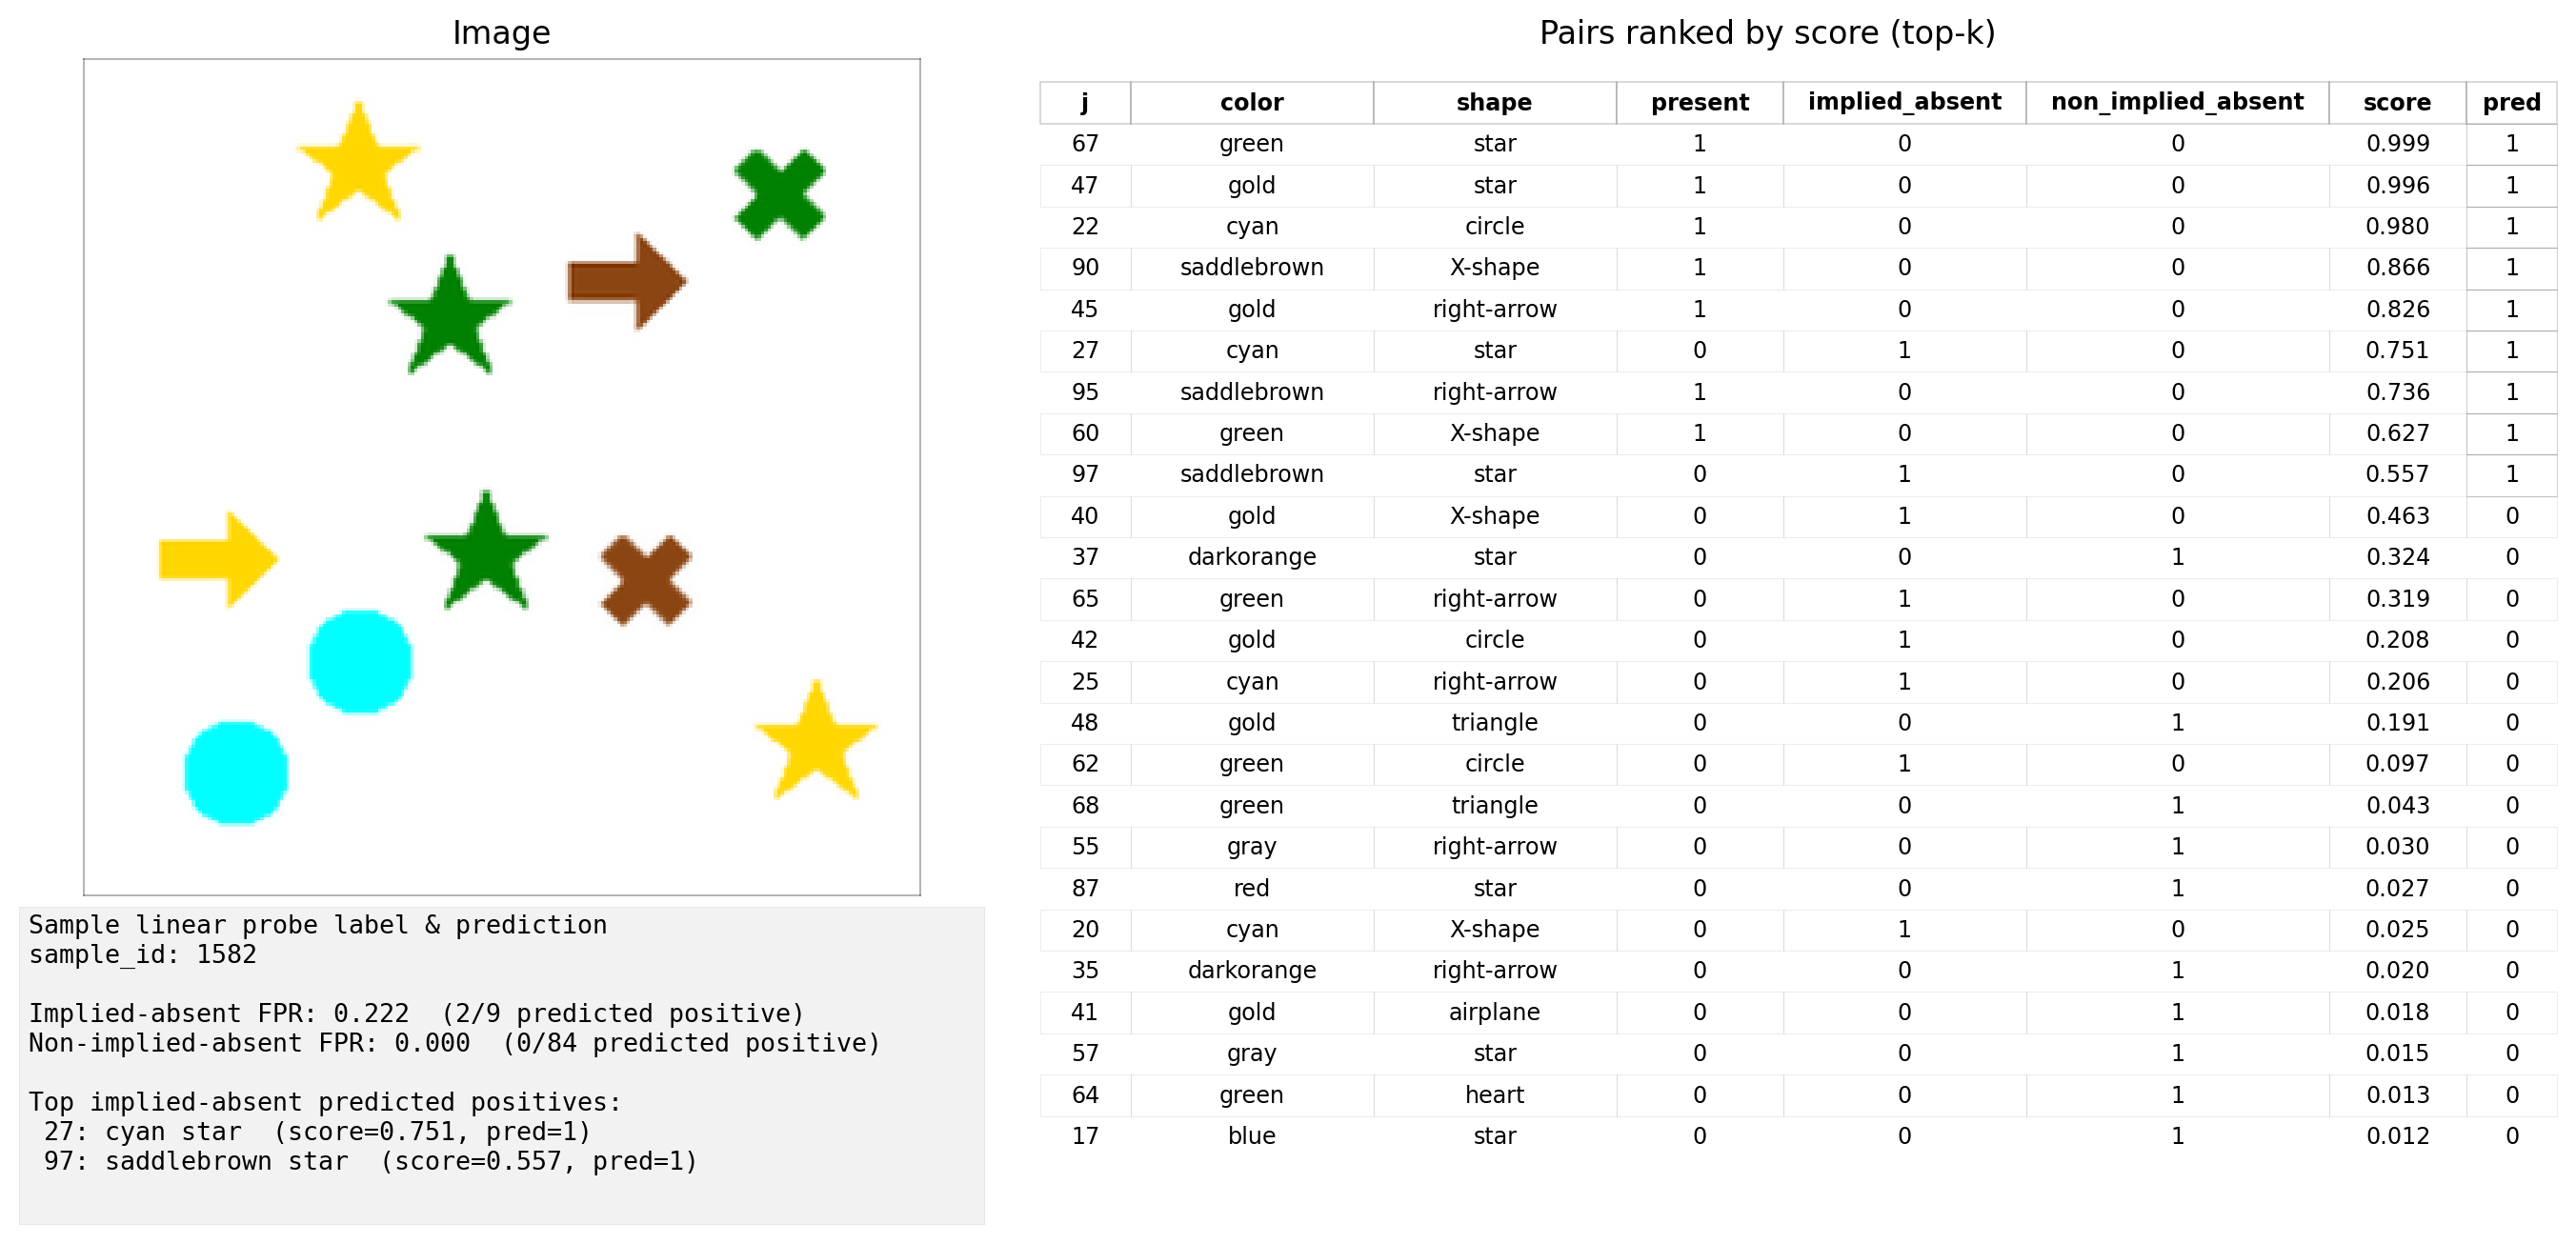

Saved figure for sample_id: 1582
Image path: data/probing/scene_description_balanced_2d/images/sample_001582.png
Implied-absent FPR: 0.2222222222222222
Non-implied-absent FPR: 0.0


In [4]:
# Cell 3 (updated): tight side-by-side figure (image + table) + FPR summaries + save to PDF

from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

def _find_image_path(sample_id: int, run_dir=None, probe_root=Path("data/probing")) -> Path:
    run_name = run_dir.parent.name if run_dir is not None else ""
    dataset_name = None

    if probe_root.exists() and run_name:
        ds_names = [d.name for d in probe_root.iterdir() if d.is_dir()]
        matches = [n for n in ds_names if run_name.startswith(n)]
        dataset_name = max(matches, key=len) if matches else None

    if dataset_name:
        images_dir = probe_root / dataset_name / "images"
        hits = sorted(images_dir.glob(f"sample_{sample_id:06d}.*"))
        if hits:
            return hits[0]

    hits = sorted(probe_root.glob(f"*/images/sample_{sample_id:06d}.*"))
    if hits:
        return hits[0]

    raise FileNotFoundError(f"Could not find image for sample_id={sample_id} under {probe_root}/**/images/")


def render_probe_appendix_figure(
    z,
    i: int,
    run_dir=None,
    topk: int = 25,
    implied_list_k: int = 8,
    fig_width: float = 13.5,
    fig_height: float = 6.8,
    dpi: int = 200,
    save_pdf: str | None = None,
    save_png: str | None = None,
):
    """
    Produces one combined appendix-style figure:
      - Left: Image + sample-level summary (FPR implied/non-implied + top implied-absent positives)
      - Right: Table of top-k pairs ranked by score
    Optionally saves to PDF/PNG.
    """

    # ---- Pull metadata / arrays
    pair_colors = z["pair_colors"] if "pair_colors" in z else None
    pair_shapes = z["pair_shapes"] if "pair_shapes" in z else None

    y_present = z["y_present"][i].astype(int)
    y_implied = z["y_implied_absent"][i].astype(int)
    y_non_impl = z["y_non_implied_absent"][i].astype(int)
    y_score = z["y_score"][i].astype(float)
    y_pred = z["y_pred"][i].astype(int)

    # sample_id
    sample_id = int(z["sample_id"][i]) if "sample_id" in z else int(i)

    # ---- Build pair table
    rows = []
    for j in range(len(y_score)):
        color = str(pair_colors[j]) if pair_colors is not None else str(j)
        shape = str(pair_shapes[j]) if pair_shapes is not None else ""
        rows.append((j, color, shape, y_present[j], y_implied[j], y_non_impl[j], y_score[j], y_pred[j]))

    df = pd.DataFrame(
        rows,
        columns=["j", "color", "shape", "present", "implied_absent", "non_implied_absent", "score", "pred"],
    ).sort_values("score", ascending=False)

    # ---- Compute stratified FPRs (mean(pred) over each absent subgroup)
    implied_mask = y_implied.astype(bool)
    non_impl_mask = y_non_impl.astype(bool)

    implied_fpr = float(y_pred[implied_mask].mean()) if implied_mask.any() else np.nan
    non_impl_fpr = float(y_pred[non_impl_mask].mean()) if non_impl_mask.any() else np.nan

    n_implied = int(implied_mask.sum())
    n_non_impl = int(non_impl_mask.sum())
    implied_pos = int(y_pred[implied_mask].sum()) if implied_mask.any() else 0
    non_impl_pos = int(y_pred[non_impl_mask].sum()) if non_impl_mask.any() else 0

    # implied-absent list for the bottom-left panel (sorted by score desc)
    implied_df = df[df["implied_absent"] == 1].copy().sort_values("score", ascending=False)
    implied_pos_df = implied_df[implied_df["pred"] == 1].head(implied_list_k)

    def fmt_pair_row(r):
        return f"{int(r['j']):>3d}: {r['color']} {r['shape']}  (score={r['score']:.3f}, pred={int(r['pred'])})"

    if len(implied_pos_df) > 0:
        implied_lines = [fmt_pair_row(r) for _, r in implied_pos_df.iterrows()]
        implied_block = "\n".join(implied_lines)
    else:
        implied_block = "(none predicted positive)"

    # ---- Load image
    img_path = _find_image_path(sample_id, run_dir=run_dir)
    img = Image.open(img_path).convert("RGB")

    # ---- Create figure layout (tight + paper-ish)
    plt.close("all")
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    gs = fig.add_gridspec(
        nrows=1, ncols=2,
        width_ratios=[1.05, 1.65],
        wspace=0.02
    )

    # Left: image + summary text below (use sub-gridspec)
    gs_left = gs[0, 0].subgridspec(nrows=2, ncols=1, height_ratios=[1.0, 0.38], hspace=0.02)
    ax_img = fig.add_subplot(gs_left[0, 0])
    ax_txt = fig.add_subplot(gs_left[1, 0])

    # Force bottom text panel to exactly match image width
    pos_img = ax_img.get_position()
    pos_txt = ax_txt.get_position()
    ax_txt.set_position([pos_img.x0, pos_txt.y0, pos_img.width, pos_txt.height])

    # Right: table
    ax_tbl = fig.add_subplot(gs[0, 1])

    # ---- Left: Image panel
    ax_img.imshow(img)
    ax_img.set_title("Image", fontsize=12, pad=6)
    ax_img.set_xticks([])
    ax_img.set_yticks([])
    for spine in ax_img.spines.values():
        spine.set_linewidth(0.6)
        spine.set_alpha(0.35)

    # ---- Left bottom: sample summary (label/pred + FPRs)
    # "Sample linear probe label and prediction" — we’ll present the key outcome metrics:
    # implied/non-implied FPR and counts (+ top implied positives).
    ax_txt.axis("off")
    ax_txt.set_xlim(0, 1)
    ax_txt.set_ylim(0, 1)
    
    summary_lines = [
        "Sample linear probe label & prediction",
        f"sample_id: {sample_id}",
        "",
        f"Implied-absent FPR: {implied_fpr:.3f}  ({implied_pos}/{n_implied} predicted positive)",
        f"Non-implied-absent FPR: {non_impl_fpr:.3f}  ({non_impl_pos}/{n_non_impl} predicted positive)",
        "",
        "Top implied-absent predicted positives:",
        implied_block,
    ]
    
    # Background panel that spans the *exact* image width
    rect = plt.Rectangle(
        (0.0, 0.0),
        1.0,
        1.0,
        transform=ax_txt.transAxes,
        linewidth=0.6,
        edgecolor="black",
        facecolor="black",
        alpha=0.05,
        zorder=-1,
    )
    ax_txt.add_patch(rect)
    
    # Text anchored to the same left edge as the image
    ax_txt.text(
        0.01, 0.98,   # tiny inset so text doesn’t touch border
        "\n".join(summary_lines),
        va="top",
        ha="left",
        fontsize=9.6,
        family="monospace",
        linespacing=1.25,
        transform=ax_txt.transAxes,
    )


    # ---- Right: Table panel (top-k ranked by score)
    ax_tbl.set_title("Pairs ranked by score (top-k)", fontsize=12, pad=6)
    ax_tbl.axis("off")

    top = df.head(topk).copy()
    top_display = top.copy()
    top_display["score"] = top_display["score"].map(lambda x: f"{x:.3f}")

    # Make table
    cell_text = top_display.values.tolist()
    col_labels = list(top_display.columns)

    tbl = ax_tbl.table(
        cellText=cell_text,
        colLabels=col_labels,
        loc="upper left",
        cellLoc="center",
        colLoc="center",
        edges="closed",
    )

    # Styling: tighter rows, readable header, subtle banding
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8.6)

    # Column width hints (matplotlib is imperfect; this helps)
    # Emphasize color/shape and score/pred columns
    col_widths = {
        "j": 0.06,
        "color": 0.16,
        "shape": 0.16,
        "present": 0.11,
        "implied_absent": 0.16,
        "non_implied_absent": 0.20,
        "score": 0.09,
        "pred": 0.06,
    }
    # Normalize widths to sum ~ 1.0
    total_w = sum(col_widths.get(c, 0.12) for c in col_labels)
    norm = {c: col_widths.get(c, 0.12) / total_w for c in col_labels}

    nrows = len(cell_text) + 1  # includes header
    ncols = len(col_labels)

    for (r, c), cell in tbl.get_celld().items():
        cell.set_linewidth(0.4)
        cell.set_height(1.0 / (nrows + 2.2))  # tighter
        # header row
        if r == 0:
            cell.set_text_props(weight="bold")
            cell.set_alpha(0.18)
            cell.set_linewidth(0.6)
        else:
            # subtle banding
            if r % 2 == 0:
                cell.set_alpha(0.07)
            else:
                cell.set_alpha(0.0)

            # highlight predicted positives a bit (subtle)
            # pred column index
            pred_col = col_labels.index("pred")
            if c == pred_col and str(cell.get_text().get_text()) == "1":
                cell.set_alpha(0.18)

        # apply column widths
        col_name = col_labels[c]
        cell.set_width(norm[col_name])

    # Tighten outer margins (good for PDF appendix)
    fig.subplots_adjust(left=0.02, right=0.995, top=0.93, bottom=0.03)

    # ---- Save outputs
    if save_pdf is not None:
        fig.savefig(save_pdf, format="pdf", bbox_inches="tight", pad_inches=0.02)
    if save_png is not None:
        fig.savefig(save_png, format="png", bbox_inches="tight", pad_inches=0.02)

    # Show in notebook
    plt.show()

    return {
        "sample_id": sample_id,
        "img_path": str(img_path),
        "implied_fpr": implied_fpr,
        "non_implied_fpr": non_impl_fpr,
        "df": df,
    }


# ------------------------
# Usage (flexible):
# ------------------------
# Choose which sample to inspect:
# i = 0  # you already set this above
out_dir = Path("figures/appendix")
out_dir.mkdir(parents=True, exist_ok=True)
out = render_probe_appendix_figure(
    z=z,
    i=i,
    run_dir=run_dir if "run_dir" in globals() else None,
    topk=25,
    implied_list_k=8,
    save_pdf=str(out_dir / f"appendix_probe_sample_{sample_id}.pdf"),
    save_png=str(out_dir / f"appendix_probe_sample_{sample_id}.png"),
)

print("Saved figure for sample_id:", out["sample_id"])
print("Image path:", out["img_path"])
print("Implied-absent FPR:", out["implied_fpr"])
print("Non-implied-absent FPR:", out["non_implied_fpr"])
